# Finetuning tha last year of fine-rune model

In [1]:
import os
ml_code_path='/home/leilapirhaji/mz_embed_engine/ml'
os.chdir(ml_code_path)

import pandas as pd
import importlib
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import optuna
import imaplib


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import random
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score


#importing fundtion to get encoder info and perfrom tasks 
from get_finetune_encoder import  get_finetune_input_data

from models_VAE import VAE

%who



[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
2024-09-11 21:12:23.768757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-11 21:12:23.789747: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-11 21:12:23.796282: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-11 21:12:23.813627: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions

DataLoader	 LabelEncoder	 TensorDataset	 VAE	 accuracy_score	 f1_score	 get_finetune_input_data	 imaplib	 importlib	 
label_encoder	 ml_code_path	 nn	 np	 optim	 optuna	 os	 pd	 precision_score	 
random	 recall_score	 roc_auc_score	 torch	 


## gettin the model ID and info

#### getting the input data

In [2]:
#input data
input_data_location='/home/leilapirhaji/PROCESSED_DATA_2'
finetune_save_dir='/home/leilapirhaji/finetune_VAE_models' 

#tasks to predict using encoder
task_list_cat=['Benefit BINARY', 'Nivo Benefit BINARY', 'MSKCC BINARY', 'IMDC BINARY', 'Benefit ORDINAL', 'MSKCC ORDINAL', 'IMDC ORDINAL', 'ORR', 'Benefit', 'IMDC', 'MSKCC', 'Prior_2' ]

#survival tasks
task_list_survival=[ 'OS', 'OS_Event', 'PFS', 'PFS_Event' ]


#get fine-tuning input data 
(X_data_train, y_data_train, X_data_val, y_data_val, X_data_test, y_data_test)=get_finetune_input_data(input_data_location)

X_data_train.shape, y_data_train.shape, X_data_val.shape, y_data_val.shape, X_data_test.shape, y_data_test.shape

((443, 2736), (443, 58), (149, 2736), (149, 58), (149, 2736), (149, 58))

### loading the fine-tune VAE models w/wo transfer leanrning

In [3]:
#loading the VAE modesl developed with and without transfer leanring

pretrain_model_ID='RCC-37520'

#path to pre-train and fine-tune models
models_path=f'{finetune_save_dir}/{pretrain_model_ID}'

#pretrain encoder file
pretrain_encoder_file= f'{models_path}/{pretrain_model_ID}_encoder_state_dict.pth'

#finetune models files
finetune_VAE_TL_file= f'{models_path}/Finetune_VAE_pretain_{pretrain_model_ID}_TL_True_model.pth'
finetune_VAE_TL=torch.load(finetune_VAE_TL_file)

finetune_VAE_noTL_file= f'{models_path}/Finetune_VAE_pretain_{pretrain_model_ID}_TL_False_model.pth'
finetune_VAE_noTL=torch.load(finetune_VAE_noTL_file)

/var/tmp/ipykernel_3676368/2107314632.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  finetune_VAE_TL=torch.load(finetune_VAE_TL_file)
/var/tmp/ipykernel_3676368/210731

In [80]:
finetune_VAE_TL.latent_size, finetune_VAE_TL.num_hidden_layers, finetune_VAE_noTL.latent_size, finetune_VAE_noTL.num_hidden_layers

(176, 2, 176, 2)

## Perdciting tasks from latnet space

In [40]:
#tasks to predict using encoder
task_list_cat=['Benefit BINARY', 'Nivo Benefit BINARY', 'MSKCC BINARY', 'IMDC BINARY', 'Benefit ORDINAL', 'MSKCC ORDINAL', 'IMDC ORDINAL', 'ORR', 'Benefit', 'IMDC', 'MSKCC', 'Prior_2' ]

task= 'IMDC BINARY'


import latent_task_predict
import ml.latent_task_predict_main as latent_task_predict_main

importlib.reload(latent_task_predict_main)
importlib.reload(latent_task_predict)

from ml.latent_task_predict_main import predict_task_from_latent_avg



best_val_accuracy, best_val_auc, test_accuracy, test_auc= predict_task_from_latent_avg (finetune_VAE_TL, task, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

best_val_accuracy, best_val_auc, test_accuracy, test_auc

Test Accuracy with best model: 0.8070
Test AUC with best model: 0.8977


(0.7868852459016393,
 0.8974358974358975,
 0.8070175438596491,
 0.8976982097186701)

In [34]:
best_val_accuracy, test_accuracy= predict_task_from_latent_avg (finetune_VAE_noTL, task, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

best_val_accuracy, test_accuracy

Test Accuracy with best model: 0.5789


(0.7049180327868853, 0.5789473684210527)

## Predicting Survival from latnent avergae

### OS prediction

In [43]:
import latent_task_predict
import ml.latent_task_predict_main as latent_task_predict_main

importlib.reload(latent_task_predict_main)
importlib.reload(latent_task_predict)

from ml.latent_task_predict_main import predict_survival_from_latent_avg

task= 'OS'
task_event='OS_Event'

best_val_c_index, best_test_c_index, best_params= predict_survival_from_latent_avg (finetune_VAE_TL, task, task_event, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

best_val_c_index, best_test_c_index, best_params

(0.7067302811897269, 0.6180839397866613, {'penalizer': 10, 'l1_ratio': 0})

In [45]:
best_params['penalizer']

0.1

### PFS Predictions

In [44]:
task= 'PFS'
task_event='PFS_Event'

best_val_c_index, best_test_c_index, best_params= predict_survival_from_latent_avg (finetune_VAE_TL, task, task_event, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

best_val_c_index, best_test_c_index, best_params

(0.6064707126242335, 0.51573082805331, {'penalizer': 0.1, 'l1_ratio': 0})

## VAE model with fine-tuned last layer

In [5]:
#loading the seed file
with open('/home/leilapirhaji/mz_embed_engine/ml/seed_Aug31.txt', 'r') as f:
    seed = int(f.read())

In [6]:
y_data_val['MSKCC ORDINAL'].describe()

count    149.000000
mean       1.174497
std        0.723463
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: MSKCC ORDINAL, dtype: float64

In [115]:
hidden_layers = encoder_layers[:-1]
hidden_layers

[Linear(in_features=2736, out_features=981, bias=True),
 Linear(in_features=981, out_features=352, bias=True)]

In [126]:
encoder_layers = [layer for layer in finetune_VAE_TL.encoder.network.children() if isinstance(layer, nn.Linear)]
encoder_layers



[Linear(in_features=2736, out_features=981, bias=True),
 Linear(in_features=981, out_features=352, bias=True),
 Linear(in_features=352, out_features=352, bias=True)]

In [130]:
import imaplib
import freez_encoder_latent_avg
importlib.reload(freez_encoder_latent_avg)
from freez_encoder_latent_avg import fine_tune_model

task='IMDC BINARY'
num_classes = 2

model, metrics = fine_tune_model(
    VAE_model=finetune_VAE_TL,  # VAE model with transfer learning 
    X_train=X_data_train, 
    y_data_train=y_data_train[task],
    X_val=X_data_val, 
    y_data_val=y_data_val[task], 
    num_classes=num_classes, 
    num_layers_to_retrain=3, 
    add_post_latent_layers=False, 
    num_post_latent_layers=1, 
    post_latent_layer_size=32, 
    num_epochs=20, 
    batch_size=32, 
    learning_rate=1e-5, 
    dropout=0.25, 
    l1_reg_weight=1e-7, 
    l2_reg_weight=1e-7, 
    latent_passes=10, 
    seed=seed # Set seed for reproducibility
    )

model



Total hidden layers (excluding latent): 3
Number of layers to retrain: 3
network.0.weight: requires_grad = False
network.0.bias: requires_grad = False
network.3.weight: requires_grad = False
network.3.bias: requires_grad = False
network.6.weight: requires_grad = False
network.6.bias: requires_grad = False

After unfreezing:
network.0.weight: requires_grad = True
network.0.bias: requires_grad = True
network.3.weight: requires_grad = True
network.3.bias: requires_grad = True
network.6.weight: requires_grad = True
network.6.bias: requires_grad = True
Epoch 1/20, Loss: 0.00010329243325811279
Epoch 2/20, Loss: 0.00010417186214389014
Epoch 3/20, Loss: 0.00010063631011040084
Epoch 4/20, Loss: 0.0001008155673584302
Epoch 5/20, Loss: 9.951359762843432e-05
Epoch 6/20, Loss: 9.932893902129893e-05
Epoch 7/20, Loss: 9.788441353261337e-05
Epoch 8/20, Loss: 9.731639927070188e-05
Epoch 9/20, Loss: 9.775282160262577e-05
Epoch 10/20, Loss: 9.653707352949173e-05
Epoch 11/20, Loss: 9.66111355020465e-05
E

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



FineTuneModel(
  (encoder): Dense_Layers(
    (network): Sequential(
      (0): Linear(in_features=2736, out_features=981, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.16024047402106825, inplace=False)
      (3): Linear(in_features=981, out_features=352, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Dropout(p=0.16024047402106825, inplace=False)
      (6): Linear(in_features=352, out_features=352, bias=True)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=176, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [81]:
model

FineTuneModel(
  (encoder): Dense_Layers(
    (network): Sequential(
      (0): Linear(in_features=2736, out_features=981, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.16024047402106825, inplace=False)
      (3): Linear(in_features=981, out_features=352, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Dropout(p=0.16024047402106825, inplace=False)
      (6): Linear(in_features=352, out_features=352, bias=True)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=176, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

## Latent Avergaing - training last layer of the encoder to predict classification tasks 

In [121]:
#makign seeds that are the same for all the tasks
#import set_seed
#from set_seed import set_seed
#seed = set_seed(42)  # Explicitly set and save the seed

#with open('/home/leilapirhaji/mz_embed_engine/ml/seed_Aug31.txt', 'w') as f:
#    f.write(str(seed))
#loading the seed file
with open('/home/leilapirhaji/mz_embed_engine/ml/seed_Aug31.txt', 'r') as f:
    seed = int(f.read())

### optuna optimization

In [133]:
import optuna

import imaplib
import freez_encoder_latent_avg
importlib.reload(freez_encoder_latent_avg)
from freez_encoder_latent_avg import fine_tune_model, FineTuneModel

task='IMDC BINARY'
num_classes = 2

best_model = None  # Variable to store the best model
best_auc = -float('inf')  # Initialize to a very low value to keep track of the best AUC

def objective(trial):
    global best_model, best_auc
    
    # Hyperparameters to optimize
    add_post_latent_layers = trial.suggest_categorical('add_post_latent_layers', [True, False])
    # Conditionally suggest post_latent_layer_size only if add_post_latent_layers is True
    if add_post_latent_layers:
        post_latent_layer_size = trial.suggest_categorical('post_latent_layer_size', [8, 32, 64, 128])
    else:
        post_latent_layer_size = 1  # or set a default value if needed
  
    num_layers_to_retrain = trial.suggest_categorical('num_layers_to_retrain', [0, 1, 2, 3])
    
    num_epochs = trial.suggest_int('num_epochs', 20, 20)
    batch_size = trial.suggest_categorical('batch_size', [32])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.4)
    l1_reg_weight = trial.suggest_loguniform('l1_reg_weight', 1e-8, 1e-3)
    l2_reg_weight = trial.suggest_loguniform('l2_reg_weight', 1e-8, 1e-3)

    # Perform fine-tuning with the current hyperparameters
    model, metrics = fine_tune_model(
        VAE_model=finetune_VAE_TL,  # VAE model with transfer learning 
        X_train=X_data_train, 
        y_data_train=y_data_train[task],
        X_val=X_data_val, 
        y_data_val=y_data_val[task], 
        num_classes=num_classes, 
        num_layers_to_retrain=num_layers_to_retrain, 
        add_post_latent_layers=add_post_latent_layers, 
        num_post_latent_layers=1, 
        post_latent_layer_size=post_latent_layer_size, 
        num_epochs=num_epochs, 
        batch_size=batch_size, 
        learning_rate=learning_rate, 
        dropout=dropout, 
        l1_reg_weight=l1_reg_weight, 
        l2_reg_weight=l2_reg_weight, 
        latent_passes=10, 
        seed=seed # Set seed for reproducibility
    )

    
    # Use the AUC score from the last epoch as the objective to maximize
    auc = metrics['AUC'].iloc[-1]

    # Save the model if it has the best AUC so far
    if auc > best_auc:
        best_auc = auc
        best_model = model

    #saving the best model
    torch.save(best_model, f'{models_path}/pre-train_{pretrain_model_ID}_finetune_{task}_best_model.pth')  # Save the best model

    return auc


# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(f"Best trial: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_trial.params}")


[I 2024-09-12 02:00:19,376] A new study created in memory with name: no-name-dd7b20a6-ea31-4dba-993c-fd73f50835ca
/var/tmp/ipykernel_3676368/2100941295.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2100941295.py:30: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2100941295.py:31: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2100941295.py:32: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

Epoch 1/20, Loss: 0.0011147456908864634
Epoch 2/20, Loss: 0.0010993389628960618
Epoch 3/20, Loss: 0.0010821122975487793
Epoch 4/20, Loss: 0.0010716489715767758
Epoch 5/20, Loss: 0.0010594292294367083
Epoch 6/20, Loss: 0.0010512050108185836
Epoch 7/20, Loss: 0.0010392904431293054
Epoch 8/20, Loss: 0.0010308471475062625
Epoch 9/20, Loss: 0.0010260091179848782
Epoch 10/20, Loss: 0.0010165193317724125
Epoch 11/20, Loss: 0.0010134272077786072
Epoch 12/20, Loss: 0.0010038250807805785
Epoch 13/20, Loss: 0.000992686886872564
Epoch 14/20, Loss: 0.0009914677315724216
Epoch 15/20, Loss: 0.0009819774630679084
Epoch 16/20, Loss: 0.0009749736345838755
Epoch 17/20, Loss: 0.0009696895555992212
Epoch 18/20, Loss: 0.0009651254721185458
Epoch 19/20, Loss: 0.0009642310947778501
Epoch 20/20, Loss: 0.0009512040872193341
Validation started
Validation Loss: 0.7527214092202484, Accuracy: 86.88524590163934%, Precision: 79.16666666666666%, Recall: 86.36363636363636%, F1 Score: 82.6086956521739%, AUC: 91.60839160

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 02:00:22,610] Trial 0 finished with value: 91.6083916083916 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 9.012481593756706e-06, 'dropout': 0.26337697478754024, 'l1_reg_weight': 1.2758946817890347e-06, 'l2_reg_weight': 2.333104787261186e-08}. Best is trial 0 with value: 91.6083916083916.
/var/tmp/ipykernel_3676368/2100941295.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

Epoch 1/20, Loss: 0.0007217064474908901
Epoch 2/20, Loss: 0.0007339291997985649
Epoch 3/20, Loss: 0.000717418230903734
Epoch 4/20, Loss: 0.0007228366947466773


[W 2024-09-12 02:00:23,005] Trial 1 failed with parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 1.6594402925907045e-06, 'dropout': 0.33782405343309313, 'l1_reg_weight': 9.455816328298249e-07, 'l2_reg_weight': 2.4891549198472587e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/leilapirhaji/.local/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/tmp/ipykernel_3676368/2100941295.py", line 35, in objective
    model, metrics = fine_tune_model(
  File "/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py", line 445, in fine_tune_model
    latent_rep = model.encoder(inputs.to(device))
  File "/home/leilapirhaji/.local/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/leil

Epoch 5/20, Loss: 0.0007180576503742486
Epoch 6/20, Loss: 0.0007242791180033237


KeyboardInterrupt: 

#### getting optuna information

In [96]:
try:
    import optuna.visualization as vis
    vis.plot_optimization_history(study).show()
    vis.plot_param_importances(study).show()
except ImportError:
    print("Optuna visualization is not available. Install optuna[visualization] for plotting.")


In [97]:
# Convert the study trials to a DataFrame
trials_df = study.trials_dataframe()

# Extract relevant columns: AUC and hyperparameters
trials_df = trials_df[['number', 'value', 'params_num_epochs', 'params_batch_size', 'params_learning_rate', 'params_dropout', 'params_task_layer_size', 'params_l1_reg_weight', 'params_l2_reg_weight']]
trials_df.rename(columns={
    'number': 'Trial Number',
    'value': 'AUC',
    'params_num_epochs': 'Num Epochs',
    'params_batch_size': 'Batch Size',
    'params_learning_rate': 'Learning Rate',
    'params_dropout': 'Dropout',
    'params_task_layer_size': 'Task Layer Size',
    'params_l1_reg_weight': 'L1 Reg Weight',
    'params_l2_reg_weight': 'L2 Reg Weight'
}, inplace=True)

trials_df.to_csv(f'{finetune_save_dir}/optuna_trials_results.csv', index=False)

# Display the DataFrame
trials_df.head()


,Trial Number,AUC,Num Epochs,Batch Size,Learning Rate,Dropout,Task Layer Size,L1 Reg Weight,L2 Reg Weight
0,0,85.198135,39,32,0.000001,0.282627,32,1.406700e-08,7.110706e-04
1,1,89.743590,27,32,0.000003,0.136055,32,1.052606e-06,4.852945e-05
2,2,89.743590,22,32,0.000005,0.259936,32,6.886753e-06,1.151080e-06
3,3,89.860140,37,32,0.000002,0.109936,32,4.037287e-06,1.175877e-08
4,4,89.976690,30,32,0.000002,0.350291,32,1.384303e-04,1.429260e-07


In [98]:
trials_df['AUC'].max()

89.97668997668997

#### getting the best model

In [88]:

# Load the best model

best_model_file=f'{models_path}/pre-train_{pretrain_model_ID}_finetune_last_layer_best_model.pth'

best_model=torch.load(best_model_file)
best_model

/var/tmp/ipykernel_3676368/1087846431.py:5: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



FineTuneModel(
  (encoder): Dense_Layers(
    (network): Sequential(
      (0): Linear(in_features=2736, out_features=981, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.16024047402106825, inplace=False)
      (3): Linear(in_features=981, out_features=352, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Dropout(p=0.16024047402106825, inplace=False)
      (6): Linear(in_features=352, out_features=352, bias=True)
    )
  )
  (post_latent_layers): Sequential(
    (0): Linear(in_features=176, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25496769864909397, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

#### predicting the best model on the test data

In [100]:
import best_finetune_model_test_eval
importlib.reload(best_finetune_model_test_eval)
from best_finetune_model_test_eval import evaluate_model_main


(combined_result_metrics, latent_rep_train, latent_rep_val, latent_rep_test)=evaluate_model_main(best_model, X_data_train, X_data_val, X_data_test, y_data_train, y_data_val, y_data_test, task, num_classes, seed)

combined_result_metrics

Validation Loss: 0.0, Accuracy: 100.0%, Precision: 100.0%, Recall: 100.0%, F1 Score: 100.0%, AUC: 100.0%
Fine-tuning completed.
Validation Loss: 0.0, Accuracy: 83.60655737704919%, Precision: 71.42857142857143%, Recall: 90.9090909090909%, F1 Score: 80.0%, AUC: 88.92773892773893%
Fine-tuning completed.
Validation Loss: 0.0, Accuracy: 82.45614035087719%, Precision: 70.96774193548387%, Recall: 95.65217391304348%, F1 Score: 81.48148148148148%, AUC: 94.62915601023019%
Fine-tuning completed.


,Dataset,Accuracy,Precision,Recall,F1 Score,AUC,Test Loss
0,Train,100.000000,100.000000,100.000000,100.000000,100.000000,0.0
1,Validation,83.606557,71.428571,90.909091,80.000000,88.927739,0.0
2,Test,82.456140,70.967742,95.652174,81.481481,94.629156,0.0


In [91]:
latent_rep_train.shape, latent_rep_val.shape, latent_rep_test.shape

(torch.Size([443, 176]), torch.Size([149, 176]), torch.Size([149, 176]))

#### Plotting the latent space

/home/leilapirhaji/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



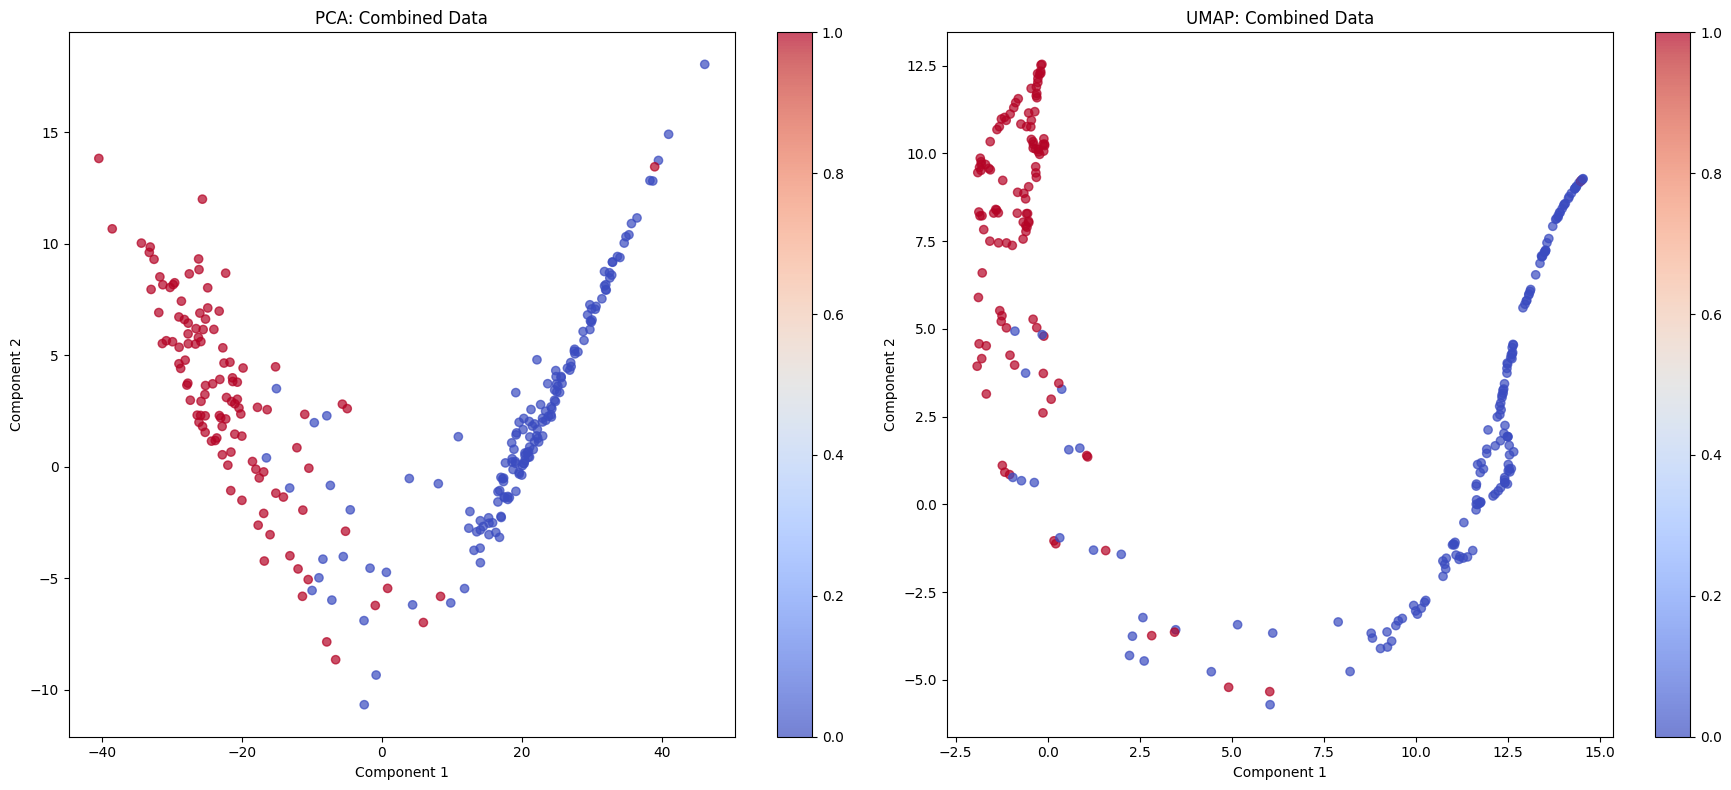

In [93]:
import matplotlib.pyplot as plt

import best_finetune_model_test_eval
importlib.reload(best_finetune_model_test_eval)
from best_finetune_model_test_eval import best_model_latent_plot_combined

fig, axes= best_model_latent_plot_combined(latent_rep_train, latent_rep_val, latent_rep_test, y_data_train, y_data_val, y_data_test, task)

plt.show()

/home/leilapirhaji/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



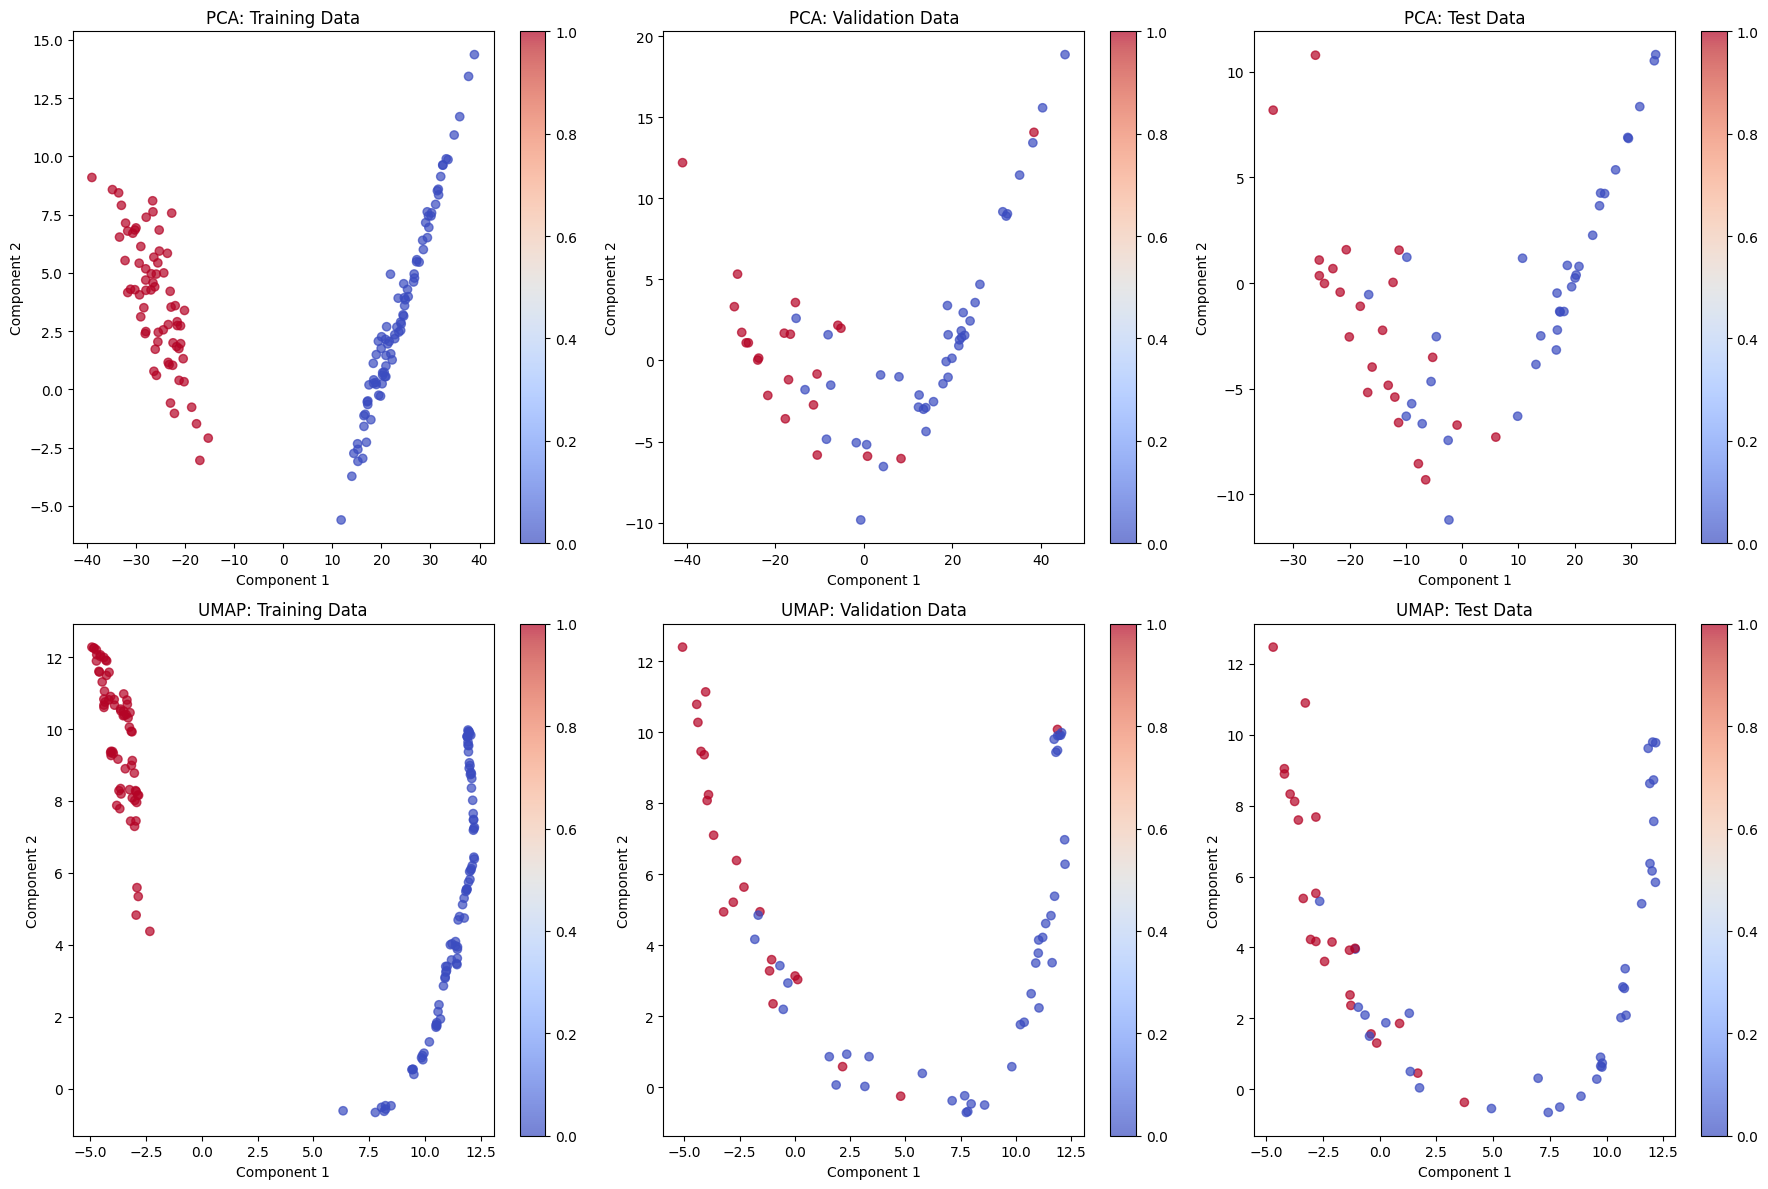

In [94]:
import matplotlib.pyplot as plt

import best_finetune_model_test_eval
importlib.reload(best_finetune_model_test_eval)
from best_finetune_model_test_eval import best_model_latent_plot


fig, axes=best_model_latent_plot(latent_rep_train, latent_rep_val, latent_rep_test, y_data_train, y_data_val, y_data_test, task)

plt.show()